# CIS 545 Final Project - Food Nutrition Analysis

#### **Yuxuan Gao, Raunaq Singh, Daniel Duan**

## Introduction

*NOTE: We originally planned to do a blog post as our deliverable, but we have instead done an annotated notebook.*

Welcome to our final project, where we conduct an analysis of food nutrition using the Open Food Facts dataset provided by Kaggle! This dataset contains nutrition facts about food products from all over the world. First, we'll spend some time cleaning up and reformatting the raw data while analyzing it for any interesting observations or correlations. Next, we'll focus on using and testing multiple models (Decision Tree, Logistic Regression, Linear Regression, Random Forest Regression) to see if we can accurately predict a product's nutrition score based on major ingredients in the product. We also will use computer vision to attempt to train a model to classify foods as "Very Healthy," "Moderately Healthy," "Moderately Unhealthy," or "Very Unhealthy" based off of their images. Lastly, we conduct a brief regression analysis on how much energy food items provide.

## Required Setup
In order to download the raw dataset from Kaggle you will need access to your Kaggle credentials (i.e. username and API Key). Here are the necessary steps to do so:
1. Create an account on [Kaggle](https://www.kaggle.com/).
2. Sign in to [Kaggle](https://kaggle.com), then click on your profile picture on the top right and select "My Account" from the menu.
3. Scroll down to the "API" section and click "Create New API Token". This will download a file `kaggle.json` with the following contents:
```
{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
```
4. When you run `od.download` (In the **Library Setup** section of the notebook), you will be asked to enter your username & Kaggle API, which you can get from the file downloaded in step 3.

## Library Setup 
Run the following cells to import the necessary packages and load the raw dataset from Kaggle into a Pandas dataframe.

In [ ]:
!pip install opendatasets
!pip3 install --upgrade mxnet-cu101 gluoncv

     |████████████████████████████████| 356.7 MB 28 kB/s 
     |████████████████████████████████| 1.3 MB 34.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from string import ascii_letters
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import sklearn as sklearn

In [ ]:
# Download raw dataset from Kaggle
od.download("https://www.kaggle.com/openfoodfacts/world-food-facts")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yuxuanmgao
Your Kaggle Key: ··········


100%|██████████| 109M/109M [00:01<00:00, 87.3MB/s]


Now let's populate our dataframe

In [ ]:
# Load tsv file into dataframe food_df
food_df = pd.read_table("world-food-facts/en.openfoodfacts.org.products.tsv", error_bad_lines=False, lineterminator='\n')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,19,20,24,25,26,28,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Awesome! Let's see what `food_df` looks like. 

In [ ]:
# See what the food_df looks like!
food_df.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,...,NaN,0.0214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,NaN,NaN,NaN,...,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.143,NaN,0.00514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,NaN,NaN,Bob's Red Mill,bob-s-red-mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,Organic polenta,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Wrangling and Cleaning
As you can see above, `food_df` is currently quite unorganized and presented in a form that is not very helpful for our purposes: there are many entires with `NaN` values in different varying columns, there are a lot of extraneous columns with few values that aren't `NaN`, some products belong to multiple countries, etc. etc. This section will focus on cleaning up `food_df` and making it more presentable.  

First, we make sure to drop any duplicate values that may appear within the dataframe.
Then, we only keep the columns with sufficient data and that are important contributors to a food's overall nutrition. For example, we will keep `fat_100g`, `cholesterol_100g`, etc. We decided to drop columns like `folates_100g` that are sparsely filled and not extremely indicative of a product's nutrition score. We mainly chose this list of columns based off of our own intutition. 

In [ ]:
# Remove duplicate values
food_df = food_df.drop_duplicates()

# Only Select columns with sufficient data and of great predictive value
food_df = food_df[["product_name", "countries_en", "image_url", "ingredients_text", "fat_100g", "cholesterol_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "sodium_100g", "energy_100g", "nutrition-score-uk_100g"]].dropna()
food_df.head(5)

,product_name,countries_en,image_url,ingredients_text,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g,nutrition-score-uk_100g
315,Sea Salt Potato Chips,United States,http://en.openfoodfacts.org/images/products/00...,"Unpeeled potatoes, sunflower oil, sea salt.",32.14,0.0000,57.14,0.00,3.600,7.14,0.375,2243.0,8.0
546,Pizza Parlanno,United States,http://en.openfoodfacts.org/images/products/00...,"Crust: _Wheat_ Flour, Water, Olive Oil, Salt,...",12.00,0.0226,25.60,3.76,0.752,9.77,0.481,1070.0,11.0
608,Mac 'n Cheese,United States,http://en.openfoodfacts.org/images/products/00...,"COOKED ELBOW MACARONI (WATER, ENRICHED SEMOLIN...",7.58,0.0202,21.20,1.52,0.505,8.08,0.298,761.0,4.0
770,Hello Panda,United States,http://en.openfoodfacts.org/images/products/00...,"Wheat flour, vegetable shortening (partially h...",26.70,0.0333,66.70,33.30,6.670,6.67,0.367,2230.0,22.0
951,sharon's sorbet mango,United States,http://en.openfoodfacts.org/images/products/00...,"Mango puree, water, cane sugar, lemon juice, p...",0.00,0.0000,26.00,25.00,1.040,0.00,0.000,435.0,5.0


`food_df` already looks much cleaner! We now have a dataframe consisting of non-empty values of important ingredients. Let's check the datatype of each remaining column.

In [ ]:
# Check data types of the columns
food_df.dtypes

product_name                object
countries_en                object
image_url                   object
ingredients_text            object
fat_100g                   float64
cholesterol_100g           float64
carbohydrates_100g         float64
sugars_100g                float64
fiber_100g                 float64
proteins_100g              float64
sodium_100g                float64
energy_100g                float64
nutrition-score-uk_100g    float64
dtype: object

Next, notice how some products appear in multiple countries (i.e. in their `countries_en` column, their value is `United States, France, Germany`). Let's split up those products using the `explode` function. 

In [ ]:
# split up proudcts that are sold in multiply countries
food_df["countries_en"]=food_df["countries_en"].str.split(",")
food_df = food_df.explode("countries_en").reset_index(drop=True)
food_df.head(5)

,product_name,countries_en,image_url,ingredients_text,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g,nutrition-score-uk_100g
0,Sea Salt Potato Chips,United States,http://en.openfoodfacts.org/images/products/00...,"Unpeeled potatoes, sunflower oil, sea salt.",32.14,0.0000,57.14,0.00,3.600,7.14,0.375,2243.0,8.0
1,Pizza Parlanno,United States,http://en.openfoodfacts.org/images/products/00...,"Crust: _Wheat_ Flour, Water, Olive Oil, Salt,...",12.00,0.0226,25.60,3.76,0.752,9.77,0.481,1070.0,11.0
2,Mac 'n Cheese,United States,http://en.openfoodfacts.org/images/products/00...,"COOKED ELBOW MACARONI (WATER, ENRICHED SEMOLIN...",7.58,0.0202,21.20,1.52,0.505,8.08,0.298,761.0,4.0
3,Hello Panda,United States,http://en.openfoodfacts.org/images/products/00...,"Wheat flour, vegetable shortening (partially h...",26.70,0.0333,66.70,33.30,6.670,6.67,0.367,2230.0,22.0
4,sharon's sorbet mango,United States,http://en.openfoodfacts.org/images/products/00...,"Mango puree, water, cane sugar, lemon juice, p...",0.00,0.0000,26.00,25.00,1.040,0.00,0.000,435.0,5.0


The dataframe looks clean and ready to use now!

## EDA
Now let's see if we can find any cool observations from the dataset using **exploratory data analysis**. 
Note that we describe and interpret any relevant findings **after** each code snippet. 



First, let's compute some simple statistics between the numeric columns in `food_df`. These columns include `fat_100g`, `cholesterol_100g`, etc. etc. 

In [ ]:
# Calculate the max, min, standard deviation, and mean of all the numeric columns
numeric_df = food_df.drop(columns=['product_name', 'countries_en', 'image_url', 'ingredients_text'])
maxes = numeric_df.max().tolist()
mins = numeric_df.min().tolist()
stds = numeric_df.std().tolist()
means = numeric_df.mean().tolist()

print(maxes)
print(mins)
print(stds)
print(means)

[100.0, 10.9, 136.0, 134.0, 66.7, 78.9, 39.0, 3925.0, 31.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -10.0]
[20.351884525580296, 0.28312752018584825, 29.44168532100894, 18.35173334958068, 4.664659377301264, 7.4847507002175515, 1.4521847474374967, 860.6874383927542, 9.27845179644698]
[15.682660904255341, 0.019502678191489355, 35.55028058510638, 13.9684953457447, 3.155960771276595, 7.382564494680877, 0.492292023375982, 1293.66621875, 8.528590425531915]


 From this, we can see that the amount of certain ingredients can vary immensely among products. For example, the calculated standard deviation of `energy_100g` is `860`. Some food products provide so much more energy than others!

Next, let's get a visual representation of the most popular ingredients used in products through a Word Cloud. 

<function matplotlib.pyplot.show>

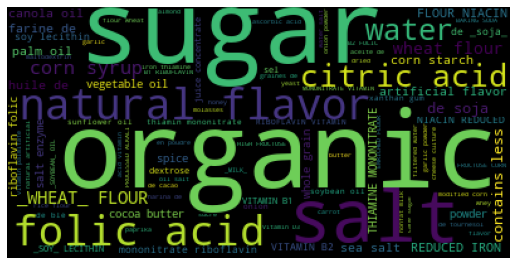

In [ ]:
# Explode the ingreidents_text
copy_food_df = food_df.copy()
copy_food_df['ingredients_text'] = copy_food_df['ingredients_text'].str.split(',').tolist()
copy_food_df = copy_food_df.explode('ingredients_text')

# generate a Word Cloud based on the ingredients
ingredients_word_cloud = WordCloud().generate(' '.join(copy_food_df['ingredients_text']))
plt.imshow(ingredients_word_cloud)
plt.axis("off")
plt.show


From this, we can see that sugar and salt seem to be the most relevant ingredients in most products, which doesn't really come of as a surprise. 

Now let's group the food products by country and visually represent each countries average nutrition score. To do this, we have to first split up foods that belong to mulitple countries using the `explode` function. Then, since some countries only have one or two food products associated with them, we should only consider countries that produce over three food products. 

***Note: The lower the nutrition score, the healthier the food is!***

Text(0.5, 1.0, 'Average Nutrition Score for Foods by Country')

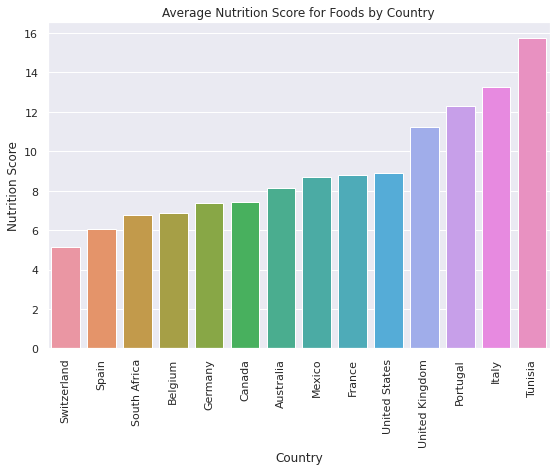

In [ ]:
#split up foods with multiply countries
food_df["countries_en"]=food_df["countries_en"].str.split(",")
country_exploded_df = food_df.explode("countries_en").reset_index(drop=True)

#only consider countries with over 3 products in the dataframe
country_count_df = country_exploded_df.groupby(["countries_en"], as_index=False).count()[["countries_en", "product_name"]]
country_count_df = country_count_df[country_count_df["product_name"] > 3]

country_nutrition_df = country_exploded_df.groupby(["countries_en"], as_index=False).mean().round(2)[["countries_en", "nutrition-score-uk_100g"]]
country_nutrition_df = country_nutrition_df.merge(country_count_df[["countries_en"]], left_on=["countries_en"], right_on=["countries_en"])

#NOTE: lower nutrition-score -> healthier
country_nutrition_df.sort_values(["nutrition-score-uk_100g"], ascending=[False])

#Map Visualization
plot = sns.barplot(x="countries_en", y="nutrition-score-uk_100g", data=country_nutrition_df, order=country_nutrition_df.sort_values(["nutrition-score-uk_100g"], ascending=[True])["countries_en"])
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Nutrition Score")
plt.title("Average Nutrition Score for Foods by Country")


Nice! Out of the countries that have more than 3 food products associated with them, our graph indicates that Switzerland produces the healthiest food items, while Tunisia products the least healthy food items. 

Next let's plot a correlation heatmap to see just how closely certain ingredients are correlated with each other. 

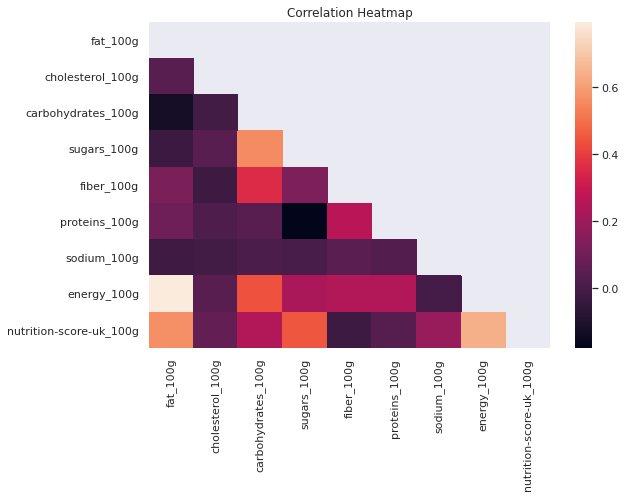

In [ ]:
# Plot correlation heatmap for all pairs of variables
sns.set(style = "white")
sns.set(rc={'figure.figsize':(9,6)})

corr = food_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask)

plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Display correlation matrix
corr

,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g,nutrition-score-uk_100g
fat_100g,1.000000,0.045731,-0.125071,-0.032149,0.123092,0.095489,-0.021479,0.792552,0.567827
cholesterol_100g,0.045731,1.000000,-0.009278,0.041228,-0.027423,0.019461,-0.007999,0.039910,0.069505
carbohydrates_100g,-0.125071,-0.009278,1.000000,0.556873,0.357107,0.040045,0.011736,0.441718,0.248067
sugars_100g,-0.032149,0.041228,0.556873,1.000000,0.128337,-0.181423,0.006351,0.229902,0.447714
fiber_100g,0.123092,-0.027423,0.357107,0.128337,1.000000,0.260167,0.049298,0.247903,-0.025244
proteins_100g,0.095489,0.019461,0.040045,-0.181423,0.260167,1.000000,0.028233,0.246367,0.038277
sodium_100g,-0.021479,-0.007999,0.011736,0.006351,0.049298,0.028233,1.000000,-0.003170,0.188552
energy_100g,0.792552,0.039910,0.441718,0.229902,0.247903,0.246367,-0.003170,1.000000,0.642317
nutrition-score-uk_100g,0.567827,0.069505,0.248067,0.447714,-0.025244,0.038277,0.188552,0.642317,1.000000


From the Correlation Heatmap, visually we can see that `fat_100g` has significant correlation with `carbohydrates_100g` and `sugars_100g` is significantly correlated with `proteins_100g`. In order to address any possible issues with multicollinearity, in our `Modeling` section we'll be sure to use PCA beforehand. 

Let's look a little more closely at how certain ingredients are correlated with a product's overall nutrition score. We'll primarily be focusing on the correlation between fat and nutrition score. Let's first run a linear regression analysis between `fat_100g` and `nutrition-score-uk_100g` and report the `R-squared` value. 

R-squared value on training set is: 32.24 %


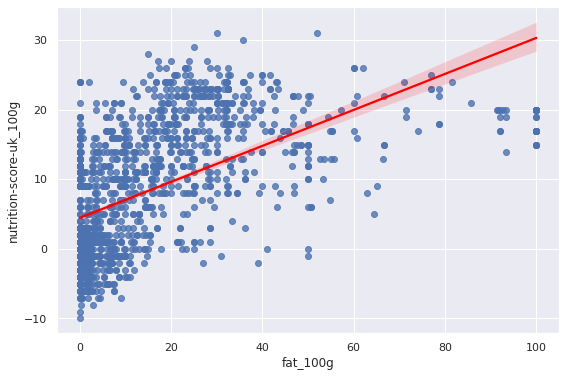

In [ ]:
# Linear regression analysis of variables fat_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(food_df['fat_100g'], food_df['nutrition-score-uk_100g'])
ax = sns.regplot(x="fat_100g", y="nutrition-score-uk_100g", data=food_df, line_kws={'color':'red'})
print("R-squared value on training set is:", round(pow(r_value, 2) * 100, 2), "%")

From this linear regression analysis we can see that the R-squared value is only 32.24%, which isn't very high. We can see visually however that there does appear to be a slight positive correlation between `fat_100g` and `nutrition-score-uk_100g`. Let's see if we can test the accuracy of our linear regression by analysing a plot of the residuals. 

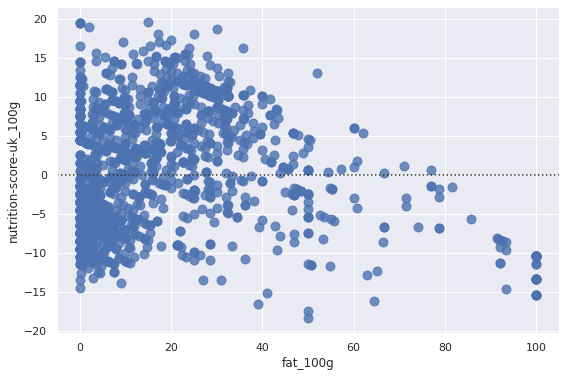

In [ ]:
# Plot residuals from the prediction
sns.residplot(x="fat_100g", y="nutrition-score-uk_100g", data=food_df, scatter_kws={"s": 80})

Hmmm... It seems that the points aren't very randomly disperesed around the horiziontal axis. Let's try our luck with a polynomial regression analysis between `fat_100g` and `nutrition-score-uk_100g`, and see if a polynomial regression model can be more accurate. 

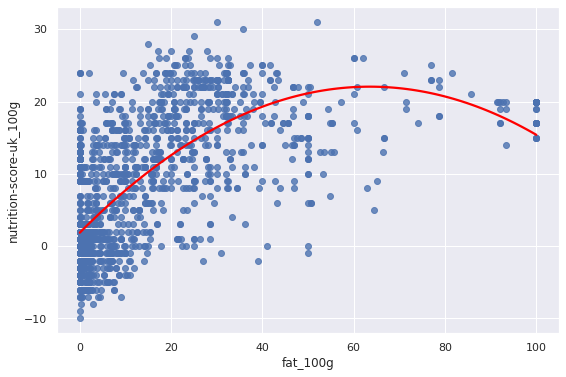

In [ ]:
# Polynomial regression analysis of variables fat_100g and nutrition-score-uk_100g
sns.set(color_codes=True)
ax = sns.regplot(x="fat_100g", y="nutrition-score-uk_100g", order=2, ci=None, data=food_df, line_kws={'color':'red'})

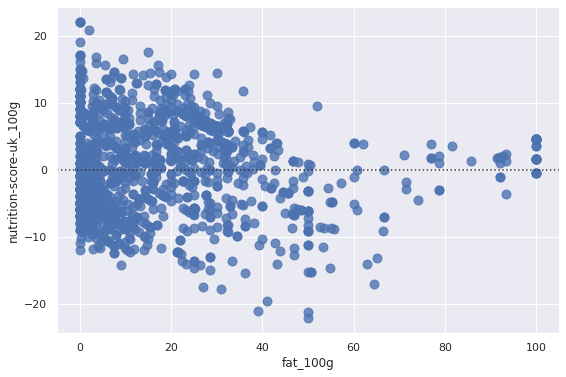

In [ ]:
# Plot residuals from the prediction
sns.residplot(x="fat_100g", y="nutrition-score-uk_100g", order=2, data=food_df, scatter_kws={"s": 80});

It seems that the data points are slighly more dispersed when compared to our analysis using `linear regression`!

In [ ]:
# Save a copy of the original dataframe
food_plain_df = food_df

## Feature Engineering
In this section let's quickly focus on **feature engineering** and see if we can further prepare our data for our machine learning algorithms, focusing on performance imporvement.  

Let's start by performing a one hot encoding of the ingredients in order to better format the data for our future machine learning algorithms. 

In [ ]:
# Perform one hot encoding of ingridients
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter

le = LabelEncoder()
all_ingredients = []

def ingredients_text_to_list(ingredients_text):
  without_parens = re.sub(r"\([^()]*\)", "", ingredients_text.lower())
  without_punc = re.sub("[^A-Za-z0-9,]+", " ", without_parens)
  ingredients_list = without_punc.split(',')
  ingredients_list = [s.strip() for s in ingredients_list]
  all_ingredients.extend(ingredients_list)
  return ingredients_list
  
def removeInsignificantElements(ingredients_list, significance):
    counted = Counter(ingredients_list)
    return [s for s in ingredients_list if (counted[s] >= significance and s and all(x.isalpha() or x.isspace() for x in s))]

def update_ingredients_list(ingredients_list):
  return [s for s in ingredients_list if s in all_ingredients]


food_df["ingredients_list"] = food_df["ingredients_text"].apply(ingredients_text_to_list)

# don't consider ingredients that appear less than 10 times
all_ingredients = removeInsignificantElements(all_ingredients, 10)

food_df["ingredients_list"] = food_df["ingredients_list"].apply(update_ingredients_list)

le.fit(all_ingredients)

for ingredient in le.classes_:
  food_df[ingredient] = 0

for index, row in food_df.iterrows():
  for ingredient in row["ingredients_list"]:
    food_df[ingredient][index] = 1

food_df = food_df.drop(['ingredients_text', 'ingredients_list'], axis=1)
food_df.head(15)

,product_name,countries_en,image_url,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g,nutrition-score-uk_100g,a b vitamin,aceite de girasol,acide citrique,agua,ail,almonds,annatto,ar me,ar me naturel,aroma,aromas,arroz integral,artificial flavor,ascorbic acid,az car,baking soda,basil,beurre de cacao,black pepper,brown sugar,butter,calcium carbonate,calcium disodium edta,cane sugar,canola oil,caramel color,carrageenan,cashews,...,soya lecithin,soybean oil,spice,spices,sucralose,sucre,sucre de canne,sugar,sunflower oil,tapioca starch,thiamin mononitrate,thiamine mononitrate,tomato concentrate,tomato paste,tomato puree,tomatoes,tricalcium phosphate,unbleached enriched flour wheat flour,vanilla,vanilla extract,vanillin,vegetable oil,vegetable oils,vinegar,vitamin a,vitamin a palmitate,vitamin c,vitamin d,water,wheat flour,wheat gluten,wheat starch,whey,whey protein concentrate,whole grain oats,whole wheat flour,xanthan gum,yeast,yeast extract,zinc oxide
0,Sea Salt Potato Chips,[United States],http://en.openfoodfacts.org/images/products/00...,32.14,0.0000,57.14,0.00,3.600,7.14,0.3750,2243.0,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pizza Parlanno,[United States],http://en.openfoodfacts.org/images/products/00...,12.00,0.0226,25.60,3.76,0.752,9.77,0.4810,1070.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,Mac 'n Cheese,[United States],http://en.openfoodfacts.org/images/products/00...,7.58,0.0202,21.20,1.52,0.505,8.08,0.2980,761.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Hello Panda,[United States],http://en.openfoodfacts.org/images/products/00...,26.70,0.0333,66.70,33.30,6.670,6.67,0.3670,2230.0,22.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,sharon's sorbet mango,[United States],http://en.openfoodfacts.org/images/products/00...,0.00,0.0000,26.00,25.00,1.040,0.00,0.0000,435.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,Spaghetti sauce with mushrooms,[United States],http://en.openfoodfacts.org/images/products/00...,0.00,0.0000,8.62,5.17,1.720,1.72,0.3190,162.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Creme Brulee,[United States],http://en.openfoodfacts.org/images/products/00...,40.00,0.0500,50.00,50.00,2.500,5.00,0.0875,2400.0,24.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Creation Hazelnut Torte Milk Chocolate,[United States],http://en.openfoodfacts.org/images/products/00...,32.50,0.0125,55.00,52.50,2.500,7.50,0.0625,2300.0,23.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Molten Lava Cake,[United States],http://en.openfoodfacts.org/images/products/00...,30.00,0.0250,55.00,50.00,2.500,5.00,0.0625,2200.0,23.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Mini Cups,[United States],http://en.openfoodfacts.org/images/products/00...,30.00,0.0167,56.70,56.70,3.330,6.67,0.0333,2230.0,21.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Synthesize indicator variable that equals to 1 if the nutritient score is above average, 0 otherwise
pd.options.mode.chained_assignment = None
food_df['nutrition_above_avg'] = food_df['nutrition-score-uk_100g'].apply(lambda x : 1 if x > food_df['nutrition-score-uk_100g'].mean() else 0)
food_df.head(15)

,product_name,countries_en,image_url,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g,nutrition-score-uk_100g,a b vitamin,aceite de girasol,acide citrique,agua,ail,almonds,annatto,ar me,ar me naturel,aroma,aromas,arroz integral,artificial flavor,ascorbic acid,az car,baking soda,basil,beurre de cacao,black pepper,brown sugar,butter,calcium carbonate,calcium disodium edta,cane sugar,canola oil,caramel color,carrageenan,cashews,...,soybean oil,spice,spices,sucralose,sucre,sucre de canne,sugar,sunflower oil,tapioca starch,thiamin mononitrate,thiamine mononitrate,tomato concentrate,tomato paste,tomato puree,tomatoes,tricalcium phosphate,unbleached enriched flour wheat flour,vanilla,vanilla extract,vanillin,vegetable oil,vegetable oils,vinegar,vitamin a,vitamin a palmitate,vitamin c,vitamin d,water,wheat flour,wheat gluten,wheat starch,whey,whey protein concentrate,whole grain oats,whole wheat flour,xanthan gum,yeast,yeast extract,zinc oxide,nutrition_above_avg
0,Sea Salt Potato Chips,[United States],http://en.openfoodfacts.org/images/products/00...,32.14,0.0000,57.14,0.00,3.600,7.14,0.3750,2243.0,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pizza Parlanno,[United States],http://en.openfoodfacts.org/images/products/00...,12.00,0.0226,25.60,3.76,0.752,9.77,0.4810,1070.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
2,Mac 'n Cheese,[United States],http://en.openfoodfacts.org/images/products/00...,7.58,0.0202,21.20,1.52,0.505,8.08,0.2980,761.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Hello Panda,[United States],http://en.openfoodfacts.org/images/products/00...,26.70,0.0333,66.70,33.30,6.670,6.67,0.3670,2230.0,22.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,sharon's sorbet mango,[United States],http://en.openfoodfacts.org/images/products/00...,0.00,0.0000,26.00,25.00,1.040,0.00,0.0000,435.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,Spaghetti sauce with mushrooms,[United States],http://en.openfoodfacts.org/images/products/00...,0.00,0.0000,8.62,5.17,1.720,1.72,0.3190,162.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Creme Brulee,[United States],http://en.openfoodfacts.org/images/products/00...,40.00,0.0500,50.00,50.00,2.500,5.00,0.0875,2400.0,24.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,Creation Hazelnut Torte Milk Chocolate,[United States],http://en.openfoodfacts.org/images/products/00...,32.50,0.0125,55.00,52.50,2.500,7.50,0.0625,2300.0,23.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,Molten Lava Cake,[United States],http://en.openfoodfacts.org/images/products/00...,30.00,0.0250,55.00,50.00,2.500,5.00,0.0625,2200.0,23.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,Mini Cups,[United States],http://en.openfoodfacts.org/images/products/00...,30.00,0.0167,56.70,56.70,3.330,6.67,0.0333,2230.0,21.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Check data types of the columns
food_df.dtypes

product_name            object
countries_en            object
image_url               object
fat_100g               float64
cholesterol_100g       float64
                        ...   
xanthan gum              int64
yeast                    int64
yeast extract            int64
zinc oxide               int64
nutrition_above_avg      int64
Length: 213, dtype: object

## Modeling

### Structure Train & Test Datasets - Nutrition Score Classification

Let's first use `nutrition_above_avg` as our response variable and conduct classification. We will utilize Sklearn's built-in packages to split the training and test sets.

In [ ]:
# Use sklearn to split data into train and test sets
from sklearn.model_selection import train_test_split

features = food_df.drop(columns=['product_name', 'countries_en', 'image_url', 'nutrition-score-uk_100g', 'nutrition_above_avg'])
labels = food_df[['nutrition_above_avg']]

print(features.head(5))
print(labels.head(5))

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)

   fat_100g  cholesterol_100g  ...  yeast extract  zinc oxide
0     32.14            0.0000  ...              0           0
1     12.00            0.0226  ...              0           0
2      7.58            0.0202  ...              0           0
3     26.70            0.0333  ...              0           0
4      0.00            0.0000  ...              0           0

[5 rows x 208 columns]
   nutrition_above_avg
0                    0
1                    1
2                    0
3                    1
4                    0


### Principal Component Analysis

To ensure that multicollinearity is not affecting our prediction and to reduce the number of features to speed things up, we first conduct a PCA analysis to extract out the most important features.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


Top 175 variables explain 97.49 % of the total variance


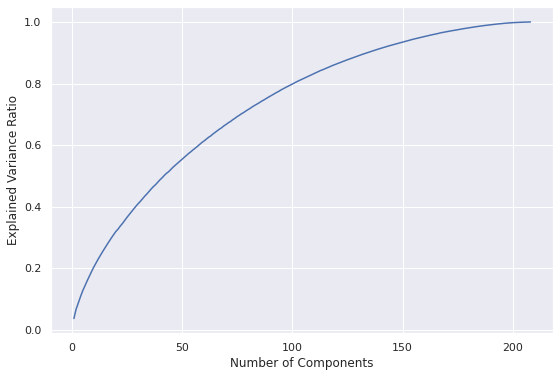

In [ ]:
# PCA analysis on useful predictors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
max = 208

thres = []
for i in range(1, max + 1):
  thres.append(i)

explained_ratio = []
explained = []
for i in range(1, max + 1):
  ratio = 0
  pca = PCA(n_components=i)
  pca.fit(x_train_scaled)
  var = pca.explained_variance_ratio_
  for x in var:
    ratio += x
  explained.append(ratio)
  if i == max:
    explained_ratio = var

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.plot(thres, explained)
print("Top 175 variables explain", round(explained[174] * 100, 2), "% of the total variance")

It appears that there is not a clear threshold after which the explained variance ratio stops to grow with the increases in the number of components. Let's print out the explained variance array to examine this issue closely.

In [ ]:
# Explained variance ratio
print(explained_ratio)

[3.66514934e-02 2.99591402e-02 2.09834871e-02 2.01031908e-02
 1.89625669e-02 1.63025716e-02 1.58458700e-02 1.54782432e-02
 1.47566149e-02 1.45025056e-02 1.32386661e-02 1.29281981e-02
 1.22110174e-02 1.18718479e-02 1.16866416e-02 1.12423955e-02
 1.10942997e-02 1.09089710e-02 1.06422848e-02 1.01709650e-02
 9.99159056e-03 9.80220782e-03 9.56450959e-03 9.42358524e-03
 9.19776129e-03 9.14558435e-03 8.85034968e-03 8.83638208e-03
 8.75098855e-03 8.53682470e-03 8.47168578e-03 8.33779643e-03
 8.14701088e-03 8.06124201e-03 7.89500052e-03 7.83143256e-03
 7.69717429e-03 7.57249381e-03 7.50130426e-03 7.42091275e-03
 7.19498798e-03 7.11202620e-03 7.01972245e-03 6.99139392e-03
 6.81858472e-03 6.74701396e-03 6.58103955e-03 6.47118551e-03
 6.39758605e-03 6.30383657e-03 6.23094246e-03 6.13188013e-03
 6.04085453e-03 6.02384329e-03 5.93847153e-03 5.89881647e-03
 5.85380884e-03 5.81835839e-03 5.75111377e-03 5.73966891e-03
 5.67427344e-03 5.57165622e-03 5.51305138e-03 5.42347064e-03
 5.40719603e-03 5.297236

It appears that there is not a set of variables that can explain the bulk of the variance. The best variable can only explain around 3.67% of the label variance. Therefore, we will select a larger amount of fetures to ensure the accuracy of our prediction. 150 seems to be a good choice as the top 175 variables can cover approximately 97.5% of the total variance.

In [ ]:
# Select 175 components according to the Elbow Rule
pca = PCA(n_components=175)
pca.fit(x_train_scaled)
x_test = pca.transform(x_test_scaled)
x_train = pca.transform(x_train_scaled)

Let's visualize the distribution of the data points with the top 2 components.

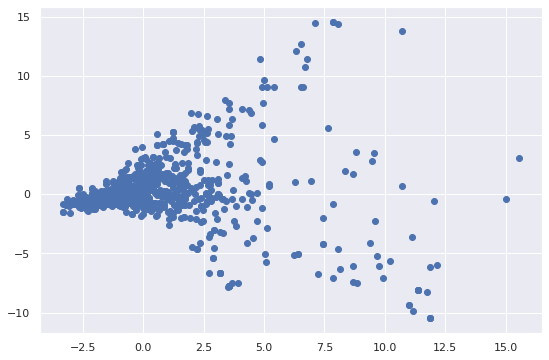

In [ ]:
# Visualize 2 components of PCA
x_train_pca = x_train_scaled
pca_plot = PCA(n_components=2)
comp = pca_plot.fit_transform(x_train_pca)
data = np.transpose(np.array(comp))
plt.scatter(data[0][0:5000], data[1][0:5000])

### Decision Tree Model

We start by trying out a decision tree model based on Naive Bayes Classifier.

In [ ]:
# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(x_train, y_train.values.ravel())
accuracy = clf.score(x_train, y_train.values.ravel())
print("Accuracy on trainig set:", round(accuracy * 100, 2), "%")

accuracy = clf.score(x_test, y_test.values.ravel())
print("Accuracy on test set:", round(accuracy * 100, 2), "%")

Accuracy on trainig set: 62.84 %
Accuracy on test set: 57.81 %


Although there the model is not overfitting, the 57.81% accuracy on the test set suggests that the performance is quite mediocre - can we do better with other classfication algorithms?

### Logistic Regression Model

Let's try using logistic regression to build the classifier.

In [ ]:
# Logistic Regression classifier
clf = LogisticRegression(max_iter=10000)
clf.fit(x_train, y_train.values.ravel())
prediction = clf.predict(x_train)
accuracy = sklearn.metrics.accuracy_score(prediction, y_train)
print("Accuracy on trainig set:", round(accuracy*100, 2), "%")

prediction = clf.predict(x_test)
accuracy = sklearn.metrics.accuracy_score(prediction, y_test)
print("Accuracy on test set:", round(accuracy*100, 2), "%")

Accuracy on trainig set: 94.93 %
Accuracy on test set: 91.69 %


Great! We reached an accuracy of 91.69% on the test set, and it seems the gap between the accuracies on the training and test sets are not that significant, which means we are not overfitting. Now we have a good model for classification, let's get back to the original `nutrition_above_avg` variable and see if we can accurately predict it using regression.

### Structure Train & Test Datasets - Nutrition Score Regression

Now, let's conduct regression on the `nutrition-score-uk_100g` variable to get a more precise predictive model. We will still conduct a PCA on the dataset and retain 175 variables since the feature set is the same as that for the previous classification model.

In [ ]:
# Use sklearn to split data into train and test sets
features = food_df.drop(columns=['product_name', 'countries_en', 'image_url', 'nutrition-score-uk_100g', 'nutrition_above_avg'])
labels = food_df[['nutrition-score-uk_100g']]

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA(n_components=175)
pca.fit(x_train_scaled)
x_test = pca.transform(x_test_scaled)
x_train = pca.transform(x_train_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


### Linear Regression Models


Let's start with the linear regression model without any regularization.

In [ ]:
# Train linear regression model without regularization
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(x_train, y_train)
print("R-squared value on training set is:", round(reg.score(x_train, y_train)*100, 2), "%")
y_predict_train = reg.predict(x_train)
rmse_train = pow(mean_squared_error(y_train, y_predict_train), 0.5)
print("RMSE on training set is:", round(rmse_train, 2))

print("R-squared value on test set is:", round(reg.score(x_test, y_test)*100, 2), "%")
y_predict_test = reg.predict(x_test)
rmse_test = pow(mean_squared_error(y_test, y_predict_test), 0.5)
print("RMSE on test set is:", round(rmse_test, 2))

R-squared value on training set is: 76.1 %
RMSE on training set is: 4.51
R-squared value on test set is: 74.02 %
RMSE on test set is: 4.84


The results are ok - we have achieved an R-squared value of 74.02% on the test set, and there is clearly no signs of overfitting.

Now, let's try adding in some degree of regularization to see if we can do even better. We will use Ridge regularization here to deal with heavier weights:

In [ ]:
# Linear regression model with Ridge regularization
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

regr = Ridge(random_state=0)
regr.fit(x_train, y_train)

y_predict_train = regr.predict(x_train)
print("R-squared value on training set is:", round(r2_score(y_predict_train, y_train)*100, 2), "%")
rmse_train = pow(mean_squared_error(y_train, y_predict_train), 0.5)
print("RMSE on training set is:", round(rmse_train, 2))

y_predict_test = regr.predict(x_test)
print("R-squared value on test set is:", round(r2_score(y_predict_test, y_test)*100, 2), "%")
rmse_test = pow(mean_squared_error(y_test, y_predict_test), 0.5)
print("RMSE on test set is:", round(rmse_test, 2))

R-squared value on training set is: 68.56 %
RMSE on training set is: 4.51
R-squared value on test set is: 67.6 %
RMSE on test set is: 4.83


Hmm...it seems the result after regularization isn't that good. We actually arrived at lower R-sqaured scores despite similar RMSE values. Therefore, we will stick to using the OLS linear regression model for now. Let's see if we can do better with more complex models.

### Random Forest Regression Model

Let's also try using a Random Forest Regressor to see if this gives us a better model for regression analysis. To find the best set of hyperparameters, we will first use a grid search to find out a good starting point for `max_depth`and `n_estimators`

In [ ]:
# Search for the optimal hyperparameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

regr = RandomForestRegressor()
depth = [5, 10, 20, 30]
estimator = [16, 32, 64, 128]
rf_cv = GridSearchCV(regr, {'max_depth': depth, 'n_estimators': estimator})

rf_cv.fit(x_train, y_train.values.ravel())
rf_cv.best_params_

{'max_depth': 30, 'n_estimators': 128}

Now we have the best set of hyperparameters, let's dive into the actual regression to see its performance.

In [ ]:
# Use the model with the best set of parameters to build the random forest
y_predict_train = rf_cv.predict(x_train)
print("R-squared value on training set is:", round(r2_score(y_predict_train, y_train)*100, 2), "%")
rmse_train = pow(mean_squared_error(y_train, y_predict_train), 0.5)
print("RMSE on training set is:", round(rmse_train, 2))

y_predict_test = rf_cv.predict(x_test)
print("R-squared value on test set is:", round(r2_score(y_predict_test, y_test)*100, 2), "%")
rmse_test = pow(mean_squared_error(y_test, y_predict_test), 0.5)
print("RMSE on test set is:", round(rmse_test, 2))

R-squared value on training set is: 94.68 %
RMSE on training set is: 1.88
R-squared value on test set is: 54.34 %
RMSE on test set is: 4.88


The R-square value of the prediction on the training set is significantly better than the previous regression models, but there exists a major gap between the R-squared values of the predictions on the training and test sets, which indicates that the model is overfitting. Let's try some degree of regularization to see if the problem goes away.

In [ ]:
# Tune hyperparameters to avoid overfit
regr = RandomForestRegressor(max_depth = 5, n_estimators = 16)
regr.fit(x_train, y_train.values.ravel())
y_predict_train = regr.predict(x_train)
print("R-squared value on training set is:", round(r2_score(y_predict_train, y_train)*100, 2), "%")
rmse_train = pow(mean_squared_error(y_train, y_predict_train), 0.5)
print("RMSE on training set is:", round(rmse_train, 2))

y_predict_test = regr.predict(x_test)
print("R-squared value on test set is:", round(r2_score(y_predict_test, y_test)*100, 2), "%")
rmse_test = pow(mean_squared_error(y_test, y_predict_test), 0.5)
print("RMSE on test set is:", round(rmse_test, 2))

R-squared value on training set is: 59.1 %
RMSE on training set is: 4.39
R-squared value on test set is: 33.08 %
RMSE on test set is: 5.5


We see that even when we prune the trees in the random forest and limit the number of trees, the gap between the R-squared values of predictions on the training and test sets still exist. This indicates that random forest regressor is probably not a good model for conducting regression on our dataset.

### Computer Vision

In this section, we will attempt to train a model to classify foods as "Very Healthy," "Moderately Healthy," "Moderately Unhealthy," or "Very Unhealthy" from their images.

First, let's classify each food's nutrition level in the dataframe:

In [ ]:
pd.set_option('display.max_colwidth', None)
food_img_df = food_df[["product_name", "image_url", "nutrition-score-uk_100g"]]

def classify_nutrition(nutrition_score):
  if (nutrition_score <= food_img_df[["nutrition-score-uk_100g"]].quantile(0.25)["nutrition-score-uk_100g"]):
    return "Very Healthy"
  elif (nutrition_score <= food_img_df[["nutrition-score-uk_100g"]].quantile(0.50)["nutrition-score-uk_100g"]):
    return "Moderately Healthy"
  elif (nutrition_score <= food_img_df[["nutrition-score-uk_100g"]].quantile(0.75)["nutrition-score-uk_100g"]):
    return "Moderately Unhealthy"
  return "Very Unhealthy"
  
food_img_df["nutrition-class"] = food_img_df["nutrition-score-uk_100g"].apply(classify_nutrition)

food_img_df.head(5)

,product_name,image_url,nutrition-score-uk_100g,nutrition-class
0,Sea Salt Potato Chips,http://en.openfoodfacts.org/images/products/00005487/front.3.400.jpg,8.0,Moderately Healthy
1,Pizza Parlanno,http://en.openfoodfacts.org/images/products/00025157/front.6.400.jpg,11.0,Moderately Unhealthy
2,Mac 'n Cheese,http://en.openfoodfacts.org/images/products/00036559/front.5.400.jpg,4.0,Moderately Healthy
3,Hello Panda,http://en.openfoodfacts.org/images/products/000/807/710/2146/front.6.400.jpg,22.0,Very Unhealthy
4,sharon's sorbet mango,http://en.openfoodfacts.org/images/products/000/907/310/2963/front.3.400.jpg,5.0,Moderately Healthy


We split up our dataframe into train, validation, and test data:

In [ ]:
from sklearn.model_selection import train_test_split

food_img_train_df, food_img_test_df = train_test_split(food_img_df, test_size=0.2)
food_img_train_df, food_img_val_df = train_test_split(food_img_train_df, test_size=0.125)

Next, we download the food images into the appropriate folders for classification. This may take a little while.

In [ ]:
import os
import requests
import re

def download_images(row):
   global imgCount, rootFolder, numImgs

   filename = os.path.join(rootFolder, row["nutrition-class"], re.sub(r'[^a-zA-Z0-9]', '', str(row.product_name)) + ".jpg")

   os.makedirs(os.path.dirname(filename), exist_ok=True)

   url = row.image_url
   print(f"Downloading {url} to {filename}")
   r = requests.get(url, allow_redirects=True)
   with open(filename, 'wb') as f:
       f.write(r.content)
       imgCount = imgCount + 1
       print(str(imgCount/numImgs * 100) + "%")

imgCount = 0
rootFolder = "/content/train/"
numImgs = len(food_img_train_df)
food_img_train_df.apply(download_images, axis=1)

imgCount = 0
rootFolder = "/content/test/"
numImgs = len(food_img_test_df)
food_img_test_df.apply(download_images, axis=1)

imgCount = 0
rootFolder = "/content/val/"
numImgs = len(food_img_val_df)
food_img_val_df.apply(download_images, axis=1)

0.09505703422053231%
0.19011406844106463%
0.28517110266159695%
0.38022813688212925%
0.4752851711026616%
0.5703422053231939%
0.6653992395437262%
0.7604562737642585%
0.8555133079847909%
0.9505703422053232%
1.0456273764258555%
1.1406844106463878%
1.2357414448669202%
1.3307984790874523%
1.4258555133079849%
1.520912547528517%
1.6159695817490494%
1.7110266159695817%
1.8060836501901139%
1.9011406844106464%
1.9961977186311788%
2.091254752851711%
2.1863117870722433%
2.2813688212927756%
2.376425855513308%
2.4714828897338403%
2.5665399239543727%
2.6615969581749046%
2.7566539923954374%
2.8517110266159698%
2.9467680608365017%
3.041825095057034%
3.1368821292775664%
3.2319391634980987%
3.326996197718631%
3.4220532319391634%
3.5171102661596962%
3.6121673003802277%
3.70722433460076%
3.802281368821293%
3.897338403041825%
3.9923954372623576%
4.08745247148289%
4.182509505703422%
4.277566539923954%
4.3726235741444865%
4.467680608365019%
4.562737642585551%
4.657794676806084%
4.752851711026616%
4.84790874524

1173    None
1094    None
1139    None
875     None
521     None
        ... 
1043    None
613     None
522     None
1462    None
836     None
Length: 151, dtype: object

In [ ]:
import os
import shutil

train_path="/content/train"
test_path="/content/test"
val_path="/content/val"

print(os.listdir(train_path))
print(os.listdir(test_path))
print(os.listdir(val_path))

['Very Unhealthy', 'Very Healthy', 'Moderately Healthy', 'Moderately Unhealthy']
['Very Unhealthy', 'Very Healthy', 'Moderately Healthy', 'Moderately Unhealthy']
['Very Unhealthy', 'Very Healthy', 'Moderately Healthy', 'Moderately Unhealthy']


**We have successfully downloaded our images, let's get to the fun stuff!**


Importing the required packages:

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

We compute numpy arrays for the images in the training, test, and validation sets:

In [ ]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)


x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

Transforming the range of image pixels from [0, 255] to [0, 1]:

In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 953 images belonging to 4 classes.
Found 290 images belonging to 4 classes.
Found 149 images belonging to 4 classes.


In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [ ]:
training_set.class_indices

{'Moderately Healthy': 0,
 'Moderately Unhealthy': 1,
 'Very Healthy': 2,
 'Very Unhealthy': 3}

We will use the VGG-19 pre-trained model:

In [ ]:
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

We make sure the output size of our model is 4 (the number of classes we are classifying):

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In order to reduce overfitting, we want to stop training our model when our validation loss increases in two epochs:

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=2)

Let's get to training!

In [ ]:
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x, val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32, shuffle=True)

Epoch 1/10
30/30 [==============================] - 717s 24s/step - loss: 2.1434 - accuracy: 0.2487 - val_loss: 1.7224 - val_accuracy: 0.2953
Epoch 2/10
30/30 [==============================] - 702s 24s/step - loss: 0.9534 - accuracy: 0.6118 - val_loss: 1.4234 - val_accuracy: 0.3020
Epoch 3/10
30/30 [==============================] - 712s 24s/step - loss: 0.6046 - accuracy: 0.8206 - val_loss: 1.4642 - val_accuracy: 0.2953
Epoch 4/10
30/30 [==============================] - 722s 24s/step - loss: 0.4029 - accuracy: 0.9265 - val_loss: 1.5483 - val_accuracy: 0.3289
Epoch 00004: early stopping


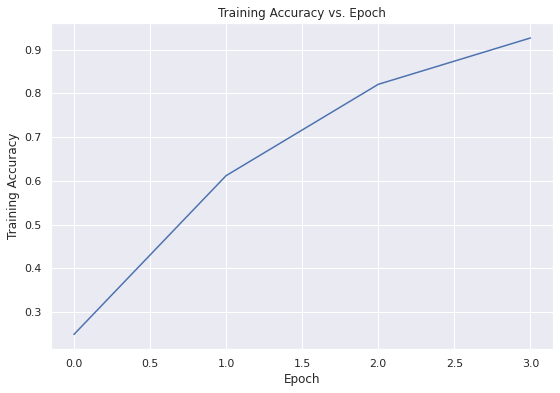

In [ ]:
plt.plot(history.history['accuracy'])
plt.title("Training Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.show()

In this plot, we can see the training accuracy of our model increase significantly over 4 epochs.

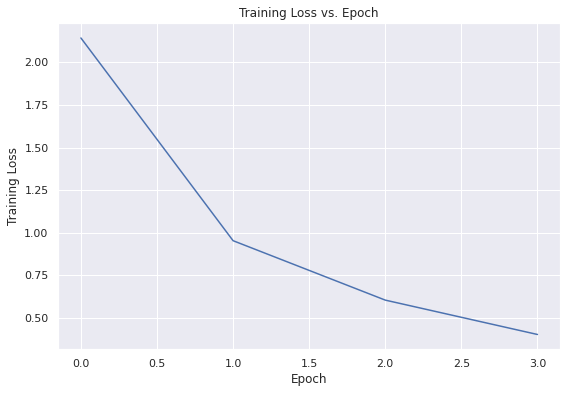

In [ ]:
plt.plot(history.history['loss'])
plt.title("Training Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

And this plot shows the training loss of our model decrease significantly over 4 epochs.

Finally, let's evaluate our model on the test set!

In [ ]:
model.evaluate(test_x, test_y, batch_size=32)

10/10 [==============================] - 185s 18s/step - loss: 1.3612 - accuracy: 0.4345


[1.3611738681793213, 0.43448275327682495]

**Our model had a final accuracy of 43.45% on the test set.**

While this is not very high, it is clear our model has some success (we expect only a 25% accuracy if we randomly guessed the classification for each food based off its image).

On top of this, the task at hand for the model is very difficult. There are not many (if any) clear features of food images that give away whether the food is very healthy, moderately healthy, moderately unhealthy, or very unhealthy.

### Pipeline Regression Analysis - Energy Score

Lastly, we will construct a pipeline to conduct linear regression for the `energy_100g` of all types of food

In [ ]:
# Use sklearn to split data into train and test sets
features = food_df.drop(columns=['product_name', 'countries_en', 'image_url', 'energy_100g', 'nutrition-score-uk_100g', 'nutrition_above_avg'])
labels = food_df[['energy_100g']]

print(features.head(5))
print(labels.head(5))

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)

   fat_100g  cholesterol_100g  ...  yeast extract  zinc oxide
0     32.14            0.0000  ...              0           0
1     12.00            0.0226  ...              0           0
2      7.58            0.0202  ...              0           0
3     26.70            0.0333  ...              0           0
4      0.00            0.0000  ...              0           0

[5 rows x 207 columns]
   energy_100g
0       2243.0
1       1070.0
2        761.0
3       2230.0
4        435.0


Now, let's construct a pipeline that includes variable sclaing, PCA, and linear regression to help us automate the regression.

In [ ]:
# Using a pipeline to conduct linear regression
scl = StandardScaler()
pca = PCA()
clf = LinearRegression()
pipe = Pipeline(steps=[('Scale', scl), ('PCA', pca), ('LinReg', clf)])
pipe.fit(x_train, y_train.values.ravel())

prediction = pipe.predict(x_train)
accuracy = sklearn.metrics.r2_score(prediction, y_train)
print("R-squared value on training set is:", round(accuracy*100, 2), "%")
rmse_train = pow(mean_squared_error(prediction, y_train), 0.5)
print("RMSE on training set is:", round(rmse_train, 2))

prediction = pipe.predict(x_test)
accuracy = sklearn.metrics.r2_score(prediction, y_test)
print("R-squared value on test set is:", round(accuracy*100, 2), "%")
rmse_test = pow(mean_squared_error(prediction, y_test), 0.5)
print("RMSE on test set is:", round(rmse_test, 2))

R-squared value on training set is: 95.96 %
RMSE on training set is: 168.17
R-squared value on test set is: 96.39 %
RMSE on test set is: 169.5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


Great! We achieved a 96.39% R-squared value on the test set, and overfit doesn't seem to be an issue.

As of now, we have constructed 2 accurate regression models for predicting the nutrition score and energy associated with different types of food, based on their ingredients.

Thank you for taking the journey with us!

## Description of Challenges and Obstacles Faced

Originally, we planned on predicting the carbon footprint of foods in addition to the nutrition score of foods. However, we soon realized the dataset did not have nearly enough observations with carbon footprint data and had to scrap this element from our project.

In the classification and regression parts of the project, we run into the challenge of overfitting and ineffective regularization. For the random forest regressor, although the R-squared value on the training set is really high, there exists a large gap between the R-squared values of the train and test set. We had to manually reduce the number of estimators and the max depth of trees to regularize our model. For the regularized linear regression part, we started with ElasticNet, but it turned out to have very poor performance. So we tested using Lasso and Ridge regression separately to identify the issue. Through testing, we realized that Lasso regression has a poor performance, so we decided to go with the single Ridge regression.

We ran into multiple obstacles with the computer vision aspect of this project. First, we had technical difficulty getting the MXNet framework to work properly and had to switch to TensorFlow. Additionally, we faced problems with overfitting. Originally, the model had a 100% accuracy on the training data, but around a 38% accuracy on the test set. In order to address this, we added a validation set and stopped training our model when validation loss increased twice. This reduced the overfitting and improved our test accuracy to 43.45%.

## Potential Next Steps and Future Direction

There can definitely be improvements in how we first initially remove sparsely populated columns from our raw dataset. Instead of just relying on intuition to determine which columns to keep, perhaps we can algorithmically decide which columns to keep by mathematically determining how many non-null values the column has.

We are also thinking of expanding our dataset by joining the current food nutrition dataset with other food-related datasets. By doing so, we will be able to explore variables that can serve as better predictors of food nutrition scores and energy levels. Also, if we can create a large aggregation of food data, we will be able to run neural networks and deep learning models to evaluate nutrition scores and energy levels more accurately.

There is also plenty of room to improve our computer vision section. First, we can better scale up our process for retrieving images. Speeding this up is essential if we increase our image set. Additionally, although we were able to reduce overfitting in our computer vision model, it is still present. In the future, we should attempt to reduce this further by getting a better training set. We can do this by merging our current dataset with one that has better/multiple images for the foods. We can also use transformations, such as rotation and reflection, to manually augment our training set to help reduce overfitting.

Besides all the current models and objectives, we are also considering developing a recommendation system for people from different nationalities with different nutritional needs and providing a picture of the image. We can explore the popularity of food in each country and make recommendations according to their nutrition score and energy level. Then, we scan through our database of images and select the ones that match the preferences of our customers as the final output.